In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, average_precision_score,confusion_matrix,classification_report


def mean_average_precision(y_true,y_preds,classes):
    mAP = 0

    for c in classes:
        pos = c
        y_true_bin,y_preds_bin = (y_true==pos)*1,(y_preds==pos)*1
        mAP+=average_precision_score(y_true_bin,y_preds_bin)

    mAP/=len(classes)
    return mAP


class TrainLinearClassifiersFS:
    def __init__(self,
                 X_train,
                 X_test,
                 y_train,
                 y_test,
                 cv,
                 benchmark_metric = 'acc'):
        
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.cv = cv
        
        self.benchmark_metric = benchmark_metric #Unused right now
        best_model = None
        self.results = {}
        self.classes = sorted(np.unique(self.y_train))
                
    def train_cv_lin_cls(self,
                           X_train: np.array,
                           y_train: np.array,
                           X_test: np.array,
                           y_test: np.array,
                           model: tuple,
                           param_grid: dict):

        sc = StandardScaler()

        pipe = Pipeline(steps = [('standardize',sc),
                                 model])

        param_grid = {f'{model[0]}__{k}':v for k,v in param_grid.items()}


        search = GridSearchCV(pipe, param_grid, n_jobs=-1,cv = self.cv,verbose=2)
        search.fit(X_train, y_train.flatten())
        print("Best parameter (CV score=%0.4f):" % search.best_score_)
        print(search.best_params_)

        best_estimator = search.best_estimator_

        print('Retraining with full training set with optimal hparams...')
        best_estimator.fit(X_train,y_train)

        y_preds = best_estimator.predict(X_test)

        acc = accuracy_score(y_test,y_preds)
        
        mAP = mean_average_precision(y_test,y_preds,self.classes)
        

        clf_report = classification_report(y_test, y_preds, labels=self.classes,output_dict = 'dict')
        
        
        
        clf_report_df = pd.DataFrame({k:v for k,v in clf_report.items() if k in map(str,self.classes)})
        
        print("Test set accuracy=%0.4f:" % acc)

        return best_estimator,acc,mAP,clf_report_df,clf_report

    def train_models(self,
                     X_train: np.array,
                     y_train: np.array,
                     X_test: np.array,
                     y_test: np.array,
                     models: dict):
        
        results = {}
        
        for k,v in models.items():

            print(f'Training {k}...')
            results[k] = {}

            model = (k,v['model'])
            param_grid = v['param_grid']

            (results[k]['best_estimator'],
             results[k]['test_acc'],
             results[k]['test_ap'],
            results[k]['clf_report_df'],
            results[k]['clf_report']) = self.train_cv_lin_cls(X_train,
                                                              y_train,
                                                              X_test,
                                                              y_test,
                                                              model,
                                                              param_grid)

        best_model_name = max(results, key=lambda v: results[v].get('test_acc'))
        best_model = results[best_model_name]

        return best_model,results



    
    def sample_n_per_class(self,X,y,n,shuffle = True):
        sampled_ids = []
        classes = np.unique(y)
        for c in classes:
            c_ids = np.where(y.flatten()==c)[0]
            sampled_ids.extend(list(np.random.choice(c_ids,size=n,replace=False)))

        if shuffle:
            np.random.shuffle(sampled_ids)

        return X[sampled_ids],y[sampled_ids]
    
    def train_few_shot_models(self,
                              X_train: np.array,
                              y_train: np.array,
                              X_test: np.array,
                              y_test: np.array,
                              models: dict,
                              ns: list,
                              repeats: int = 5):
        
        for trial in range(repeats):
            
            self.results[trial] = {}
            
            for n in ns:
                print(f'Training with {n} observations per class...')

                X_train_fs, y_train_fs = self.sample_n_per_class(X_train,y_train,n)

                best_model,results = self.train_models(X_train_fs,
                                                       y_train_fs,
                                                       X_test,
                                                       y_test,
                                                       models)

                self.results[trial][n] = {'best_model':best_model,'results':results}

        return self.results

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

In [ ]:
X_train = np.load(f'X_train.npy')
X_test = np.load(f'X_test.npy')

y_train = np.load(f'y_train.npy')
y_test = np.load(f'y_test.npy')

In [ ]:
svm = LinearSVC(max_iter=5000,
                dual=False,
                class_weight='balanced',
                verbose=2
               )

lr = LogisticRegression(multi_class = 'multinomial',max_iter=5000)


models = {
         'SVM':
          {'model':svm,
          'param_grid':{'C':list(2**np.arange(-19,-3,1,dtype=float))+list(10**np.arange(-7,2,1,dtype=float))}
          },
          
          'LR':
          {'model':lr,
           'param_grid':{'C':10**np.linspace(-6,6,40)}
          }
         }

cv = 3
ns = [
      3,
      4,
      8,
      16,
      32,
      96
    ]
repeats = 5

In [ ]:
%%time

tlc = TrainLinearClassifiersFS(X_train,
                                 X_test,
                                 y_train,
                                 y_test,cv)
results = tlc.train_few_shot_models(X_train,
                                   y_train.flatten(),
                                   X_test,
                                   y_test.flatten(),
                                   models,
                                   ns,
                                   repeats = 5)
print(results)

Training with 3 observations per class...
Training SVM...
Fitting 3 folds for each of 25 candidates, totalling 75 fits
[LibLinear]Best parameter (CV score=0.2667):
{'SVM__C': 1.9073486328125e-06}
Retraining with full training set with optimal hparams...
[LibLinear]Test set accuracy=0.2178:
Training LR...
Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best parameter (CV score=0.3333):
{'LR__C': 0.08376776400682924}
Retraining with full training set with optimal hparams...
Test set accuracy=0.2628:
Training with 4 observations per class...
Training SVM...
Fitting 3 folds for each of 25 candidates, totalling 75 fits
[LibLinear]Best parameter (CV score=0.4267):
{'SVM__C': 0.0009765625}
Retraining with full training set with optimal hparams...
[LibLinear]Test set accuracy=0.3116:
Training LR...
Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best parameter (CV score=0.3773):
{'LR__C': 412.46263829013645}
Retraining with full training set with optimal hparams...


In [ ]:
clf_report_df = []

for n in ns:
    for r in range(repeats):
        temp = results[r][n]['best_model']['clf_report_df'].T.reset_index()
        temp['n'] = n
        clf_report_df.append(temp)

clf_report_df = pd.concat(clf_report_df)

In [ ]:
accs = []
aps = []

for i in tlc.results.keys():
    accs.append([tlc.results[i][n]['best_model']['test_acc']*100 for n in tlc.results[i].keys()])
    aps.append([tlc.results[i][n]['best_model']['test_ap']*100 for n in tlc.results[i].keys()])

In [ ]:
results_df_accs = pd.DataFrame([j for i in [list(zip(ns,i)) for i in accs] for j in i],
              columns = ['num_labeled_sampled','acc'])

results_df_maps = pd.DataFrame([j for i in [list(zip(ns,i)) for i in aps] for j in i],
              columns = ['num_labeled_sampled','mAP'])

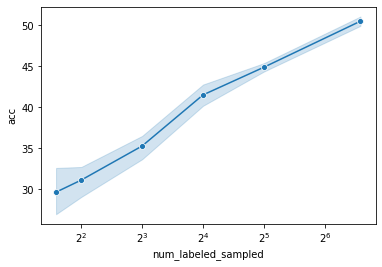

In [ ]:
ax = sns.lineplot(x='num_labeled_sampled',y='acc',marker='o',data=results_df_accs)
ax.set_xscale('log',basex=2)